In [1]:
# fix sizes of training set for unbalanced dataset
def setTrainingSize(size, ratio_1):
    a = int(size*ratio_1)
    b = size - a
    return a, b

In [2]:
max_files = 5000
num_malwares, num_good = setTrainingSize(max_files, 0.4)

#debug
print("the dataset contains",num_malwares,"malwares out of", max_files, "files")

the dataset contains 2000 malwares out of 5000 files


In [3]:
# save all malwares in a set
def loadMalwares(path):
    malwares = set()
    with open(path, "r") as fin:
        fin.readline()
        for line in fin:
            malwares.add(line.strip().split(",")[0])    
    return malwares

In [4]:
malwares_path = "drebin/sha256_family.csv"
malwares = loadMalwares(malwares_path)

In [5]:
# create a file for labels, one label per row
#    feature::stuff
#    feature::stuff2
#    ...
#    url::stuffn

from os import listdir
from os.path import isfile, join

def loadFiles(path, num_malw, num_good, malwares):
    malware_files = []
    good_files = []
    l1 = 0
    l2 = 0
    for file in listdir(path):
        if l1 >= num_malw and l2 >= num_good:
            break
        if isfile(join(path, file)):
            if file in malwares:
                if l1 < num_malw:
                    malware_files.append(file)
                    l1+=1
            elif l2 < num_good:
                good_files.append(file)
                l2+=1
    return malware_files, good_files

In [6]:
sha_path = "drebin/feature_vectors"
print("loading filenames...", flush = True)

malware_files, good_files = loadFiles(sha_path, num_malwares, num_good, malwares)
print("done", flush = True)

loading filenames...
done


In [7]:
from IPython.display import display, clear_output

good_files.extend(malware_files)
files = good_files
labels = []
labels_set = set()
i = 0
l = len(files)
cnt = 100
for file in files:
    cnt-=1
    i+=1
    if cnt == 0:
        cnt = 100
        perc = str(i) + " out of " + str(l) + " - " + str(i*100/l) + "%" 
        clear_output(wait=True)
        display("Processing " + perc + " (" + str(len(labels)) + ")")
    with open(join(sha_path, file), "r") as fin:
        for line in fin:
            line = line.strip()
            if line.startswith("api_call") or line.startswith("url") or line.startswith("activity") or line.startswith("features"):
                if line not in labels_set:
                    labels.append(line)
                    labels_set.add(line)

# debug
print("We found", len(labels), "labels")

'Processing 5000 out of 5000 - 100.0% (32642)'

We found 32642 labels


In [8]:
def saveLabels(path, labels):
    with open(path, "w") as fout:
        for label in labels:
            print(label, file=fout)

In [9]:
csv_path = "drebin/labels.txt"
saveLabels(csv_path, labels)

# debug
print("and we saved them in a file")

and we saved them in a file


In [10]:
# read labels in a dict s.t dict[label] = index (=row_number in labels file)
def loadLabels(path):
    labels = {}
    i = 0
    with open(path, "r") as fin:
        for line in fin:
            line = line.strip()
            labels[line] = i
            i+=1
    return labels

In [11]:
indexed_labels = loadLabels(csv_path)

In [12]:
# create matrix input and vector of supervsed

import numpy as np

def createDataset(path, files, malwares, labels, indexed_labels):
    m = []
    t = []

    len_files = len(files)
    len_labels = len(labels)
    cnt = 100
    i = 0
    for file in files:
        cnt-=1
        i+=1
        if cnt == 0:
            cnt = 100
            perc = str(i) + " out of " + str(l) + " - " + str(i*100/len_files) + "%" 
            clear_output(wait=True)
            display("Processing " + perc)
        with open(join(path, file), "r") as fin:
            if file in malwares:
                t.append(1)
            else:
                t.append(-1)
            vector = np.negative(np.ones(len(labels)))

            for line in fin:
                line = line.strip()
                if line in labels:
                    vector[indexed_labels[line]] = 1                
            m.append(vector)
    return m,t

In [13]:
m,t = createDataset(sha_path, files, malwares, labels, indexed_labels)
            
# debug
print("ended")

'Processing 5000 out of 5000 - 100.0%'

ended


In [14]:
from sklearn import svm
clf = svm.SVC(class_weight='balanced')
clf.fit(m,t)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
from sklearn.model_selection import cross_val_score

scoring = 'accuracy'
scores = cross_val_score(clf, m, t, cv=5, scoring = scoring)
print(scoring + ": %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

accuracy: 0.80 (+/- 0.02)


In [16]:
# build conf_matrix in cross validation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(clf, m, t, cv=5)
cnf_matrix = confusion_matrix(t, y_pred)

In [17]:
# build conf_matrix of training set (Note: use this or the previous one!!!)

#from sklearn.metrics import confusion_matrix

#predicted = []
#for k in range(len(t)):
#    predicted.append(clf.predict([m[k]])[0])

#cnf_matrix = confusion_matrix(t, predicted)

In [18]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[2764  236]
 [ 743 1257]]


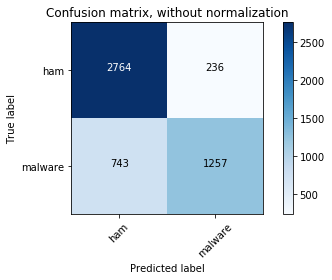

Normalized confusion matrix
[[0.92 0.08]
 [0.37 0.63]]


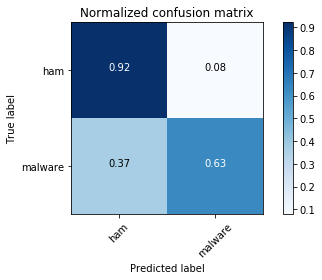

In [19]:
np.set_printoptions(precision=2)

class_names = ["good", "malware"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()